# Lab3 - Mushroom Classification
Author: David Azenda


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We are going to follow the following workflow: Split data into training and test set. Use the training portion to find the best model (optionally using grid search) and cross-validation. Evaluate the *winner* on the test set.

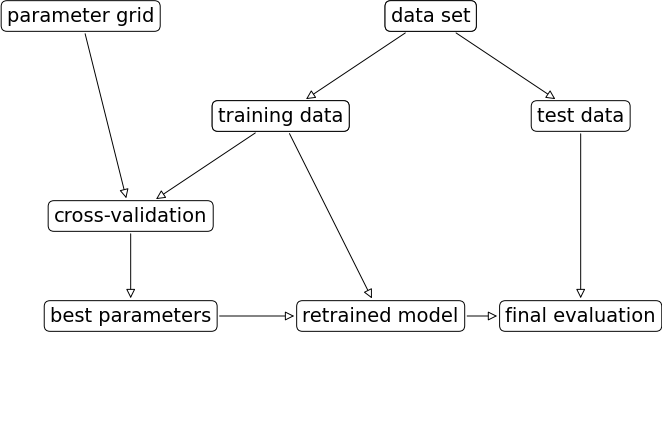

In [2]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## 0. Function definitions

from sklearn.model_selection import cross_validate


def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation scores of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    scores = cross_validate(model,X,y,cv = cv,scoring = scoring, return_train_score = True )
    train = scores['train_score'].mean()
    validation = scores['test_score'].mean()
    
    return print("Model:",model,"\nTraining score: {:.3f}".format(train), "\nValidation score: {:.3f}".format(validation),"\n")
     #TODO: implement function body
    

In [3]:
from sklearn.model_selection import cross_validate


def get_classifier_cv_score(model, X, y, scoring='average_precision', cv=7):
    '''Calculate train and validation scores of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    scores = cross_validate(model,X,y,cv = cv,scoring = scoring, return_train_score = True )
    train = scores['train_score'].mean()
    validation = scores['test_score'].mean()
    
    return model,train,validation

In [4]:
# OPTIONAL METHOD
def print_grid_search_result(grid_search):
    '''Prints summary of best model from GridSearchCV object.
    
        For the best model of the grid search, print:
        - parameters 
        - cross-validation training score
        - cross-validation validation score 
        
        scores are printed with 3 decimal places.
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        returns: None
        
    '''
    grid_search.fit(X_train, y_train)
    print("Best parameters: {}".format(grid_search.best_params_))
    print("Best cross-validation score: {:.2f}".format(grid_search.cv_results_))
    
     #TODO: implement function body
    

In [30]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [97]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    '''
    con_matrix = confusion_matrix(y_actual,y_pred)
    heat = sns.heatmap(annot = True, data = con_matrix,xticklabels = labels,yticklabels = labels,fmt = 'd',cbar = False)
    heat.set(title = title)
    heat.set(xlabel = "Predicted Value")
    heat.set(ylabel = "True Value")
    
    ;
    #TODO: implement function body
    
   

## 1. Load data
yellowbrick mushroom  
https://www.scikit-yb.org/en/latest/api/datasets/mushroom.html




### 1.1 Prepare the feature matrix and target vector

Using the yellowbrick `load_mushroom()` function, load the mushroom data set into feature matrix `X` and target vector `y`.

Print shape and type of `X`, `y`.

In [7]:
from yellowbrick.datasets import load_credit

X,y = load_credit()
print("X: ",X.shape, X.__class__)
print("y: ",y.shape, y.__class__)

X:  (30000, 23) <class 'pandas.core.frame.DataFrame'>
y:  (30000,) <class 'pandas.core.series.Series'>


In [8]:
X

,limit,sex,edu,married,age,apr_delay,may_delay,jun_delay,jul_delay,aug_delay,...,jun_bill,jul_bill,aug_bill,sep_bill,apr_pay,may_pay,jun_pay,jul_pay,aug_pay,sep_pay
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,3502,8979,5190,0,1837,3526,8998,129,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,...,2758,20878,20582,19357,0,0,22000,4200,2000,3100
29998,80000,1,3,1,41,1,-1,0,0,0,...,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804


In [9]:
y

0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: default, Length: 30000, dtype: int64

**In this data set 0 is assumed as not default and 1 is considered default.**

## 2. Inspect the data 

### 2.1 Relationship between features and target classes

To understand the relationship between categorical features and target classes better, it is usefull to produce barplots with bars for each target class. Using seaborn `countplot()`, produce a barplot for each of the three feature columns in `X` using  `y` as hue.

''

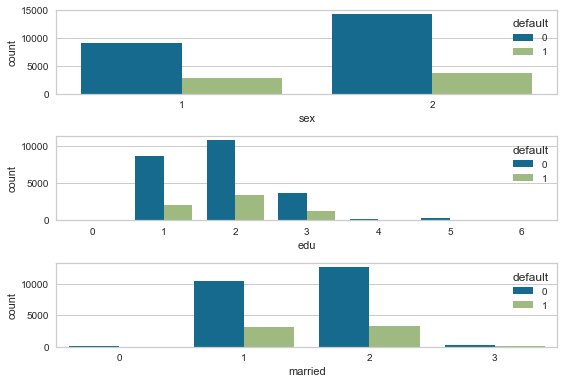

In [12]:
fig, ax = plt.subplots(3,1)
sns.countplot(x = "sex",data = X, hue= y, ax = ax[0])
sns.countplot(x = "edu",data = X, hue= y, ax = ax[1])
sns.countplot(x = "married",data = X, hue= y, ax = ax[2])
plt.tight_layout()
;

**This is a subset of all the features in this dataset.**

## 3. Preprocessing
In this dataset, all features are numeric therefore, preprocessing is not required.

## 4. Create training and test sets
Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, split `X` and `y` into training and test sets.

In [16]:
# TODO: add train_test_split() here
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 37, test_size = 0.2)

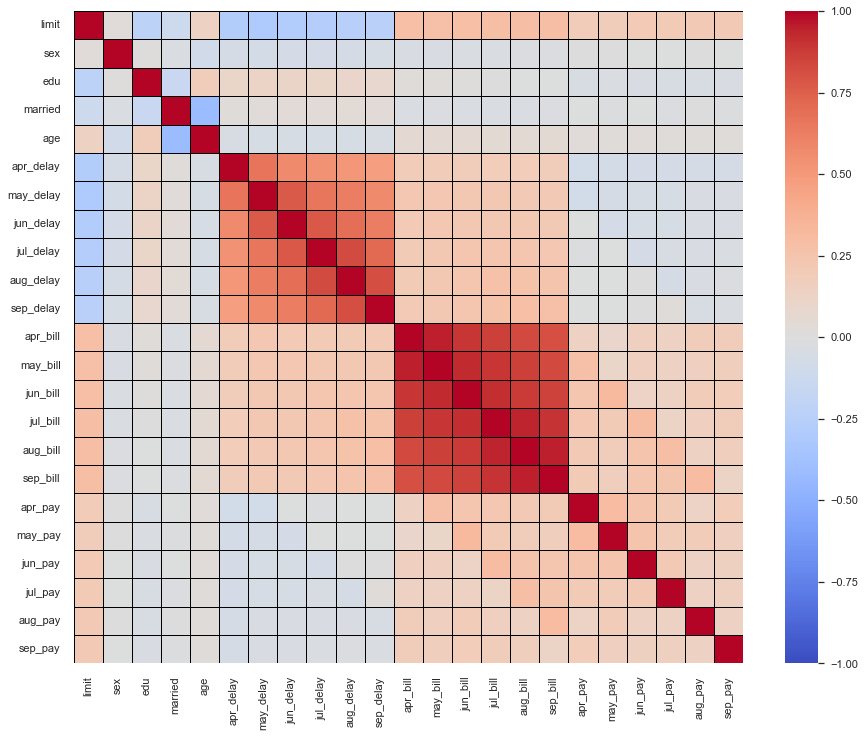

In [17]:
#Check the correlation between the features
sns.set(rc={'figure.figsize':(15,12)})
sns.heatmap(X_train.corr(),vmin= -1, vmax = 1, center = 0, cmap = 'coolwarm', linewidths = 1, linecolor = 'black');

**As we can see, there is a lot of correlation between the similarily named features in this dataset. Doing feature analysis on the dataset can reduce the correlation and improve accuracy.**

## 5. Compare models using cross-validation
Create a list containing a `LogisticRegression()`, 
          `SVC()`,
          `BernoulliNB()`,
        `RandomForestClassifier(random_state=55)`, 
         `GradientBoostingClassifier(random_state=56)` objects.

Iterate this list, then:
- compute the **average precision** using `get_classifier_cv_score()` defined above, 
- rank the models based on validation **average precision** (best first),
- and print the ranked models training and validation scores with **3 decimal places**. 

Use training data and 7-fold cross-validation.

In [18]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB

In [19]:
models = [LogisticRegression(),SVC(),BernoulliNB(),RandomForestClassifier(random_state = 55),GradientBoostingClassifier(random_state = 56)]
sortList = []
def Sort(newlist):
    newlist.sort(reverse = True,key = lambda x: x[2])
    return newlist

for m in models:
    a,b,c = get_classifier_cv_score(m,X_train,y_train)
    sortList.append([a,b,c])

/opt/anaconda3/envs/ensfml/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/ensfml/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

In [20]:
final = Sort(sortList)

In [21]:
for i in final:
    print(i[0], "Training Score:{:0.3f}".format(i[1]), "Validation Score:{:0.3f}".format(i[2]))

GradientBoostingClassifier(random_state=56) Training Score:0.605 Validation Score:0.559
RandomForestClassifier(random_state=55) Training Score:1.000 Validation Score:0.541
BernoulliNB() Training Score:0.481 Validation Score:0.481
LogisticRegression() Training Score:0.351 Validation Score:0.353
SVC() Training Score:0.334 Validation Score:0.254


## 6. Hyperparameter tuning using grid search 

The inital cross-validation above showed that both DecisionTree based models might have merit. 

Next, hyperparameters are tuned using grid search.

### 6.1 Grid search for RandomForestClassifier 

Perform grid search using `GridSearchCV` for the `RandomForestClassifier(random_state=40)`.

Grid search to use 5-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

In [42]:
from tempfile import mkdtemp
cachedir = mkdtemp()
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [23]:
estimators = [('model', LogisticRegression())]
pipe = Pipeline(estimators, memory = cachedir)

In [24]:
param_grid_RFC = [
    {'model': [RandomForestClassifier(random_state = 40)],
    'model__max_depth': [9,11,13],
    'model__n_estimators':[100,500,1000]}]    

In [25]:
grid_RFC = GridSearchCV(pipe, param_grid=param_grid_RFC, cv=5, n_jobs= 4, verbose=5,return_train_score = True,scoring = 'average_precision')

**Go grab some food this is could take a while. I like to watch the results in real time but it looks like turning on n_jobs != None stops that from happening.**

In [26]:
fitted_grid_RFC = grid_RFC.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [27]:
print(f' Best RFC Model Params: {fitted_grid_RFC.best_estimator_}\n')

 Best RFC Model Params: Pipeline(memory='/var/folders/xc/2bb9kb2j4yl6sjg90bb655s40000gn/T/tmpwztorjhn',
         steps=[('model',
                 RandomForestClassifier(max_depth=11, n_estimators=1000,
                                        random_state=40))])



In [28]:
print(f' Best RFC Model Test Score: {fitted_grid_RFC.best_score_}\n')

 Best RFC Model Test Score: 0.5638546527196558



In [75]:
print(f' Best RFC Model Test Score: {fitted_grid_RFC.cv_results_}\n')

 Best RFC Model Test Score: {'mean_fit_time': array([ 2.13681803, 10.29348278, 22.11296039,  2.91977668, 13.76941595,
       25.4550385 ,  2.81988158, 14.22342391, 27.52662449]), 'std_fit_time': array([0.02790583, 0.07334368, 1.01802986, 0.40416231, 0.32482791,
       0.59412253, 0.08720967, 0.08111833, 0.50933032]), 'mean_score_time': array([0.04472632, 0.20801301, 0.44670515, 0.0694077 , 0.30291619,
       0.49701934, 0.06070971, 0.31167612, 0.55247293]), 'std_score_time': array([0.00174908, 0.00275961, 0.03415798, 0.01469465, 0.11833891,
       0.01534973, 0.00281969, 0.03417991, 0.00820895]), 'param_model': masked_array(data=[RandomForestClassifier(max_depth=11, n_estimators=1000, random_state=40),
                   RandomForestClassifier(max_depth=11, n_estimators=1000, random_state=40),
                   RandomForestClassifier(max_depth=11, n_estimators=1000, random_state=40),
                   RandomForestClassifier(max_depth=11, n_estimators=1000, random_state=40),
         

### 6.2 Gradient boosting classifier 
Perform grid search using `GridSearchCV` for the `GradientBoostingClassifier(max_depth=5, random_state=40)`.

Grid search to use 5-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Use the following hyperparameters and values:
- `'n_estimators': [50, 100, 200]`,
- `'learning_rate': [0.001, 0.01, 0.1, 1.0]`

In [32]:
param_grid_GBC = [
    {'model': [GradientBoostingClassifier(max_depth = 5, random_state = 40)],
    'model__learning_rate': [0.001,0.01,0.1,1.0,10],
    'model__n_estimators':[50,100,200]}]  

In [33]:
grid_GBC = GridSearchCV(pipe, param_grid=param_grid_GBC, cv=5, n_jobs= 4, verbose=5,return_train_score = True,scoring = 'average_precision')

In [36]:
import time

In [37]:
start = time.time()
fitted_grid_GBC = grid_GBC.fit(X_train,y_train)
end = time.time()
print(f"Runtime of fit{end-start}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Runtime of fit238.1500632762909


In [56]:
print(f' Best GBC Model Params: {fitted_grid_GBC.best_estimator_}\n')

 Best GBC Model Params: Pipeline(memory='/var/folders/xc/2bb9kb2j4yl6sjg90bb655s40000gn/T/tmpwztorjhn',
         steps=[('model',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            n_estimators=200,
                                            random_state=40))])



In [39]:
print(f' Best GBC Model Test Score: {fitted_grid_GBC.best_score_}\n')

 Best GBC Model Test Score: 0.5605808226686297



In [74]:
print(f' Best GBC Model Test Score: {fitted_grid_GBC.cv_results_}\n')

 Best GBC Model Test Score: {'mean_fit_time': array([ 4.79330735, 10.40636258, 20.01014395,  4.7167388 ,  9.80734096,
       20.18587799,  4.47558327,  8.90125256, 17.71179991,  4.32296181,
        8.55292354, 17.38256631,  4.22709894,  8.78101225, 17.71169181]), 'std_fit_time': array([0.21518326, 0.34407947, 0.76271002, 0.1029251 , 0.16927985,
       1.15354781, 0.01680078, 0.05125491, 0.2073241 , 0.02739956,
       0.07056146, 0.09052453, 0.00974068, 0.1187197 , 0.15471741]), 'mean_score_time': array([0.01095457, 0.01776433, 0.03193326, 0.01291571, 0.01861506,
       0.03028417, 0.01014218, 0.01321626, 0.02042403, 0.0082232 ,
       0.01285915, 0.02228565, 0.0090425 , 0.01568747, 0.02950621]), 'std_score_time': array([0.0015547 , 0.00063803, 0.00276082, 0.0047693 , 0.00156468,
       0.00162748, 0.00103337, 0.00049556, 0.00042593, 0.00055264,
       0.00072354, 0.00049523, 0.00062972, 0.00165646, 0.00397931]), 'param_model': masked_array(data=[GradientBoostingClassifier(learning_rate

### 6.3 PCA and Scaling
PCA and Scaling on the pipeline. Does it have a negative or positive effect on the test scores.
Let's explore.

In [40]:
# Build and fit a PCA model to the data

# 1. Instantiate
my_pca = PCA(n_components=0.90)

# 2. Fit
my_pca.fit(X_train)

# 3. Transform
X_train_PCA = my_pca.transform(X_train)

In [55]:
X_train_PCA.shape

(24000, 2)

90% of the variance was explained in the first 2 components

In [67]:
estimatorsS = [('scale', StandardScaler()),('model', LogisticRegression())]
pipeS = Pipeline(estimatorsS, memory = cachedir)

In [57]:
param_grid_RFC_PCA = [
    {'model': [RandomForestClassifier(random_state=40)],
     'scale': [StandardScaler(),MinMaxScaler()],
    'model__max_depth': [9,11,13],
    'model__n_estimators':[100,500,1000]}]  

In [65]:
param_grid_GBC_PCA = [
    {'model': [GradientBoostingClassifier(max_depth= 5, random_state=40)],
     'scale': [StandardScaler(),MinMaxScaler()],
     'model__learning_rate': [0.001,0.01,0.1],
     'model__n_estimators':[50,100,200]}] 

Apparently I have 2 more cores to throw at this. Lets see how fast it can do it with all cores in use

In [68]:
grid_RFC_PCA = GridSearchCV(pipeS, param_grid=param_grid_RFC_PCA, cv=5, n_jobs= 6, verbose=5,return_train_score = True,scoring = 'average_precision')
grid_GBC_PCA = GridSearchCV(pipeS, param_grid=param_grid_GBC_PCA, cv=5, n_jobs= 6, verbose=5,return_train_score = True,scoring = 'average_precision')

In [62]:
start = time.time()
fitted_grid_RFC_PCA = grid_RFC_PCA.fit(X_train_PCA,y_train)
end = time.time()
print(f"Runtime of fit {end-start}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Runtime of fit 168.18208813667297


In [69]:
start = time.time()
fitted_grid_GBC_PCA = grid_GBC_PCA.fit(X_train_PCA,y_train)
end = time.time()
print(f"Runtime of fit {end-start}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Runtime of fit 47.56487488746643


In [70]:
print(f' Best RFC_PCA Model Params: {fitted_grid_RFC_PCA.best_estimator_}\n')

 Best RFC_PCA Model Params: Pipeline(memory='/var/folders/xc/2bb9kb2j4yl6sjg90bb655s40000gn/T/tmp0u8p8m7p',
         steps=[('scale', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=9, n_estimators=500,
                                        random_state=40))])



In [71]:
print(f' Best GBC_PCA Model Params: {fitted_grid_GBC_PCA.best_estimator_}\n')

 Best GBC_PCA Model Params: Pipeline(memory='/var/folders/xc/2bb9kb2j4yl6sjg90bb655s40000gn/T/tmp0u8p8m7p',
         steps=[('scale', MinMaxScaler()),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            n_estimators=200,
                                            random_state=40))])



In [73]:
print(f' Best RFC Model Test Score: {fitted_grid_RFC_PCA.best_score_}\n')
print(f' Best GBC Model Test Score: {fitted_grid_GBC_PCA.best_score_}\n')

 Best RFC Model Test Score: 0.32208640697098245

 Best GBC Model Test Score: 0.3198308090079288



From the results below we can see that PCA and Scaling have a negative impact on the test scores. Therefore, these will not be used in the retraining portion of this project

### *Question 2:* What are the training and validation scores of the two tuned (best) models and the PCA? Summarize the results here.

RandomForestClassifier
training score= 0.782; validation score=0.563

GradientBoostingClassifier
training score= 0.601; validation score=0.560

After PCA
RFC validation score= 0.322; GB validation score=0.319

From the intitial modelling, GradientBoosting had the highest score but after optimization RandomForest ended up having the best score.

## 7. (optional) Best model: Find a better threshold

### 7.1 Precision and recall curve

From the results above, it looks like `RandomForestClassifier()` performs the best.

Using the training dataset and best `RandomForestClassifier()` from the grid search above:
1. Calculate predicted probabilities using `cross_val_predict()` with parameters `cv=7, method='predict_proba'`.
2. Plot the precision-recall curve indicating where the default threshold 0.5 lies (see lecture notebook for an example).

Include a legend and axis labels.


In [76]:
#TODO: Calculate predicted probabilities using cross_val_predict(cv=7, method='predict_proba')
classifier = RandomForestClassifier(random_state= 40,n_estimators =1000,max_depth=11 )

In [77]:
#classfit = classifier.fit(X_train,y_train)

In [78]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(classifier,X_train, y_train, cv=7,method= 'predict_proba')

In [79]:
y_pred

array([[0.87680271, 0.12319729],
       [0.8799044 , 0.1200956 ],
       [0.80999985, 0.19000015],
       ...,
       [0.84062506, 0.15937494],
       [0.8804077 , 0.1195923 ],
       [0.8612952 , 0.1387048 ]])

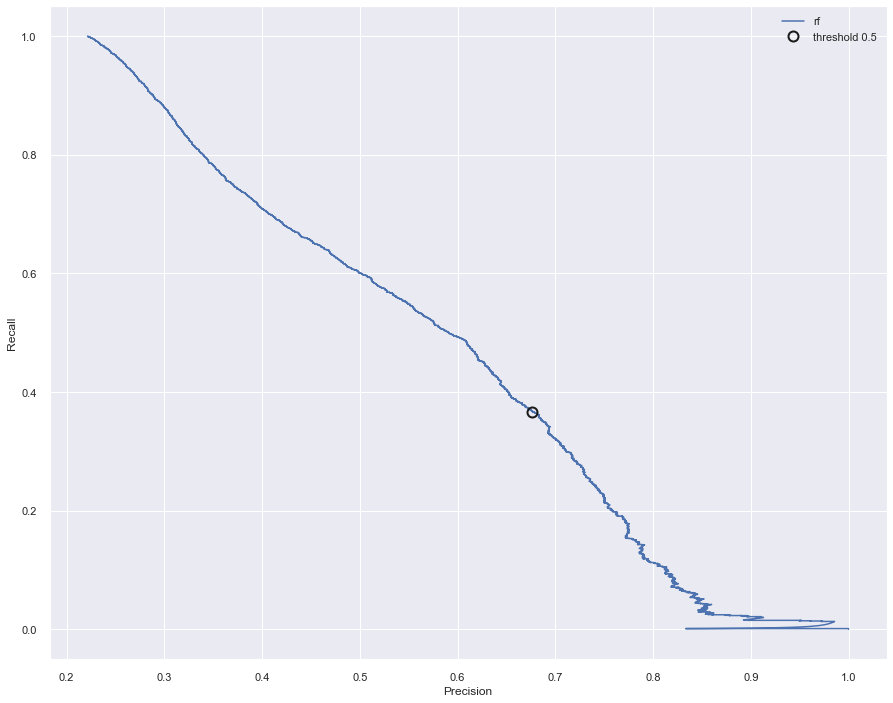

In [80]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(
    y_train,y_pred[:,1] )

plt.plot(precision, recall, label="rf")
close_default = np.argmin(np.abs(thresholds - 0.5 ))
plt.plot(precision[close_default], recall[close_default], 'o', c='k',
         markersize=10, label="threshold 0.5", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

### 7.2 Find a better threshold
It is important in this application to achieve high recall. Determine the probability threshold to achieve recall higher than 0.999. Store this threshold in a variable and print it.

In [106]:
options=np.argwhere(recall>0.999)

In [101]:
new_threshold = thresholds[124]
new_threshold0 = thresholds[0]
new_threshold62 = thresholds[62]
print(new_threshold)
print(new_threshold0)
print(new_threshold62)

0.044841806040906616
0.038317939330638734
0.04260131014110933


## 8. Retrain best model
Retrain the best `RandomForestClassifier()` from the grid search above on the training dataset.

In [83]:
fm = classifier.fit(X_train,y_train)
yfit = fm.predict(X_train)
y_test_fit = fm.predict(X_test)

## 9. Evaluate on test data

Using the retrained model and the test dataset:
- print the classification report
- plot the confusion matrix using plot_confusion_matrix()

Make sure the plot has class labels and a title.

Repeat these steps for the default threshold and the optimal threshold determined in step 7.

### 9.1 Evaluation with default threshold

In [84]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_fit))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4679
           1       0.66      0.34      0.45      1321

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.67      6000
weighted avg       0.80      0.82      0.79      6000



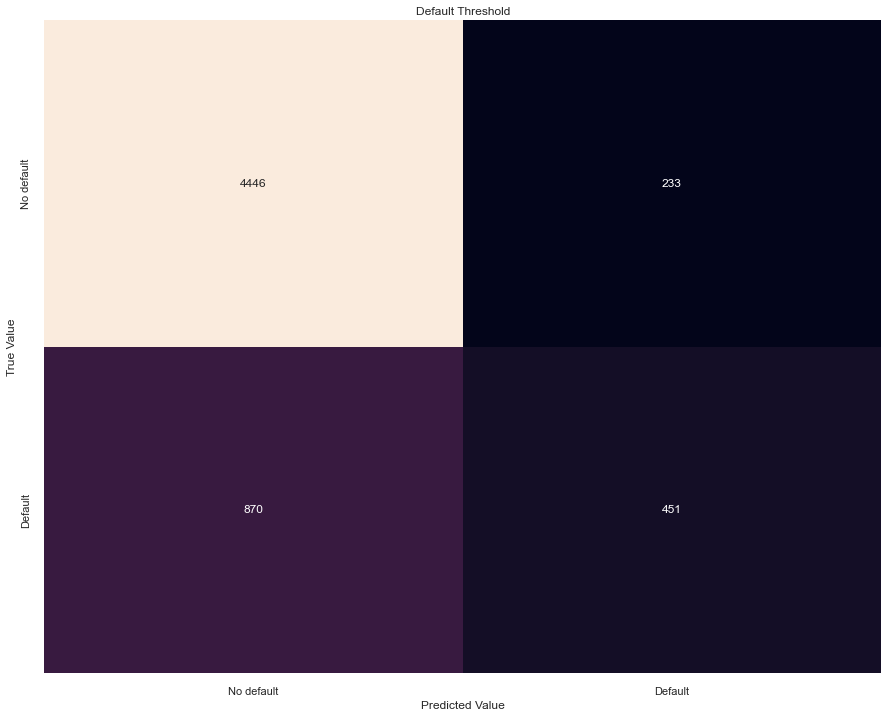

In [98]:
labels= ["No default","Default"]
plot_confusion_matrix(y_test, y_test_fit,labels, title='Default Threshold')

### 9.2 (optional) Evaluation with new threshold form Step 7.

In [87]:
y_predNT = fm.predict_proba(X_test)[:,1]>new_threshold

In [102]:
y_predNT0 = fm.predict_proba(X_test)[:,1]>new_threshold0

In [103]:
y_predNT62 = fm.predict_proba(X_test)[:,1]>new_threshold62

In [88]:
print(classification_report(y_test, y_predNT))

              precision    recall  f1-score   support

           0       1.00      0.01      0.01      4679
           1       0.22      1.00      0.36      1321

    accuracy                           0.23      6000
   macro avg       0.61      0.50      0.19      6000
weighted avg       0.83      0.23      0.09      6000



In [104]:
print(classification_report(y_test, y_predNT0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4679
           1       0.22      1.00      0.36      1321

    accuracy                           0.22      6000
   macro avg       0.11      0.50      0.18      6000
weighted avg       0.05      0.22      0.08      6000



/opt/anaconda3/envs/ensfml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ensfml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ensfml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
print(classification_report(y_test, y_predNT62))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      4679
           1       0.22      1.00      0.36      1321

    accuracy                           0.22      6000
   macro avg       0.61      0.50      0.18      6000
weighted avg       0.83      0.22      0.08      6000



**From results above the highest threshold where recall is 0.999 achieves the "best" results**

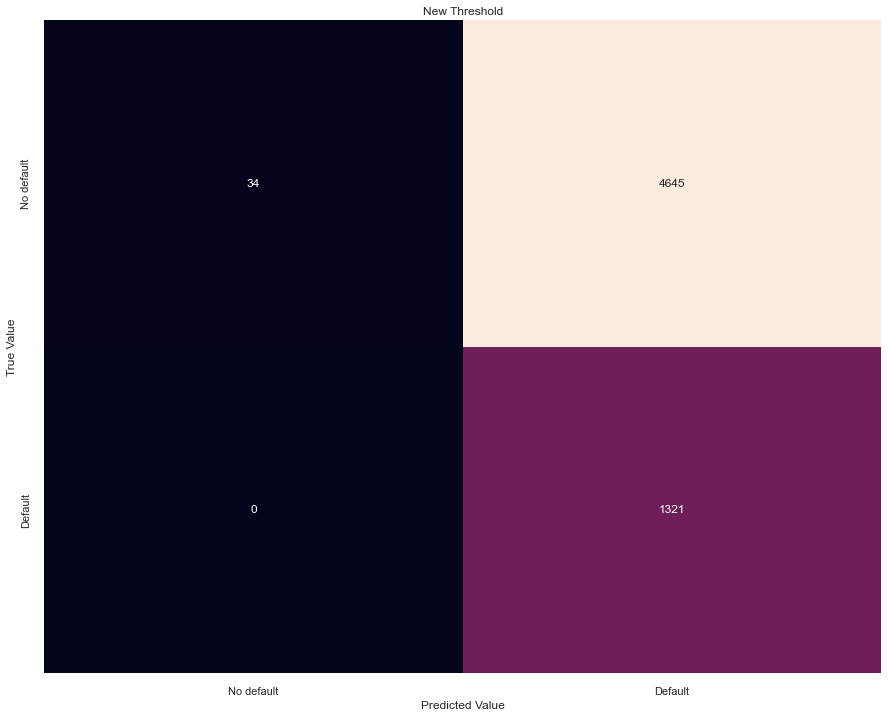

In [99]:
plot_confusion_matrix(y_test, y_predNT,labels, title='New Threshold')

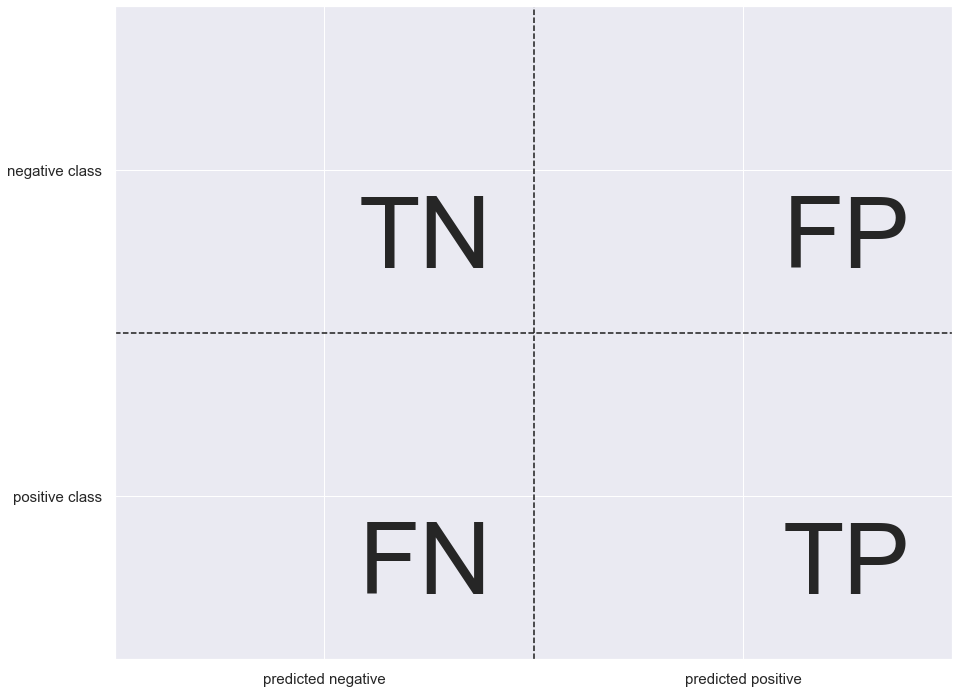

In [96]:
mglearn.plots.plot_binary_confusion_matrix()

In [92]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_test_fit)
tn, fp, fn, tp = confusion.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = (tn + tp)/(tn+fp+fn+tp)

In [93]:

confusiono = confusion_matrix(y_test,y_predNT)
tno,fpo,fno,tpo = confusiono.ravel()
precisiono = tpo/(tpo+fpo)
recallo = tpo/(tpo+fno)
accuracyo = (tno + tpo)/(tno+fpo+fno+tpo)

### *Question 3:* What are the precision, recall and accuracy on the test set using the default and optimal thresholds of the best gradient boosting model?

In [94]:
print("The Precision, Recall, and Accuracy Using the Default Threshold")
print("Precision: {:0.3f}".format(precision))
print("Recall: {:0.3f}".format(recall))
print("Accuracy: {:0.3f}".format(accuracy))
print("\nThe Precision, Recall, and Accuracy Using the Optimal Threshold")
print("Precision: {:0.3f}".format(precisiono))
print("Recall: {:0.3f}".format(recallo))
print("Accuracy: {:0.3f}".format(accuracyo))

The Precision, Recall, and Accuracy Using the Default Threshold
Precision: 0.659
Recall: 0.341
Accuracy: 0.816

The Precision, Recall, and Accuracy Using the Optimal Threshold
Precision: 0.221
Recall: 1.000
Accuracy: 0.226


### *Question 4:* How many false negatives does the model produce on the test set with the default and optimal thresholds of the best gradient boosting model?

In [95]:
print("False Negatives Using the Default Threshold: ",fn)

print("\nFalse Negatives Using the Optimal Threshold: ",fno)


False Negatives Using the Default Threshold:  870

False Negatives Using the Optimal Threshold:  0


## 10. Conclusion

In conclusion, comment on the following items:
1. In the classification of default vs non defualt, what is desired?
1. In the classification of default vs non defualt, what do false positive and false negative predictions imply and what are the consequences of making these mistakes?
1. Is the final model satisfactory, i.e. a useful model for the task, or is more work needed? Explain.

1. In this model we can assume that this data could be used by a credit evaluation company to determine who is likely to default and therefore, gives a "score" based on their credit worthiness. In this case you can argue that it is prudent to optimize the model to eliminate FNs.

The below is in reference to the optimized model..

2. Recall is important in this case because we want to ensure that whoever is using the model does not assign a non default tag to a person who is at risk of default (FN). On the other hand, individuals who were not at risk of default are regarded as potential defaulters in this model(FP).

3. From the above explanation, with a recall score of 100, the model did not have any FN which is good. Maybe some improvement can be made to increase the precision, but in this case, a perfect recall is better than perfect precision.

## 11. Reflection
Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating while working on this assignment.

It was disappointing to see the poor scores achieved. The hope was that the hyperparameter optimization would help improve the overall performance of the model but in the end only a measly 0.1 increase in validation was achieved.
One can argue that in this case scores and accuracy do not matter but, a better performing model would have yielding a higher TN result which would be seen as more desirable outcome of this threshold optimization.

I attempted to increase the performance model by performing PCA and scaling on the data but that rabbit hole yielded no gains in the score department.

To conclude, I believe that these models are not well suited for predicting the relationship between the features and the target vector. They were however suitable enough to give me a deeper understanding of hyperparameter optimzation and threshold optimization.